# Differential Expression Analysis: Host-Pathogen Interactions

## Overview

This notebook performs comprehensive differential expression analysis to identify genes responding to Klebsiella pneumoniae infection in lung macrophages. The analysis focuses on condition-based comparisons rather than computational clusters, testing key biological hypotheses about macrophage responses to bacterial infection.

## Analysis Strategy

### Key Biological Questions:

1. **General Infection Response**: How do macrophages respond to the infection environment? 
2. **Cell Type-Specific Responses**: Do alveolar and interstitial macrophages respond differently to infection?
3. **Direct Bacterial Contact**: What distinguishes cells that directly contacted bacteria from bystander cells?
4. **M(Kp) Signature Discovery**: Can we identify a novel macrophage polarization state induced by Klebsiella?

### Differential Expression Comparisons:

1. **Overall Infection Response** (Infected vs Control)
   - Identifies general immune activation signatures
   - Expected: TNF, IL1B, interferon response genes

2. **Cell Type-Specific Infection Response** (AM/IM Infected vs Control)
   - AM: Tissue homeostasis, phagocytosis specialization
   - IM: Enhanced interferon/antiviral responses (Stat1, Gbp genes)

3. **Direct Bacterial Contact** (KP+ vs KP- within infected tissue)
   - **Most Critical Analysis**: M(Kp) signature identification
   - Expected: STAT6 pathway activation, bacterial recognition genes
   - Novel antimicrobial programs distinct from general inflammation

4. **Cell Type-Specific Bacterial Contact** (AM/IM KP+ vs KP-)
   - Refined M(Kp) responses in different macrophage populations

## Expected Validation Targets

- **STAT6 pathway genes** upregulated in bacterial contact comparisons
- **Capsule polysaccharide recognition** genes
- **Novel antimicrobial programs** distinct from typical bacterial responses

In [12]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Configure scanpy settings
sc.settings.verbosity = 1
sc.settings.set_figure_params(dpi=80, facecolor='white')

## Data Loading and Preparation

### Load Clustered Dataset

In [13]:
# Load clustered dataset from notebook 3
adata = sc.read_h5ad('clustered_GSE184290.h5ad')

# Ensure optimal clustering resolution is used
sc.tl.leiden(adata, flavor="igraph", key_added="leiden", resolution=0.5)

print(f"Loaded dataset: {adata.n_obs:,} cells × {adata.n_vars:,} genes")
print(f"Clustering: {adata.obs['leiden'].nunique()} clusters at resolution 0.5")

Loaded dataset: 2,399 cells × 13,646 genes
Clustering: 10 clusters at resolution 0.5


### Create Condition and Cell Type Labels

In [14]:
# Extract cell type and condition information from existing metadata
adata.obs['cell_type'] = adata.obs['condition'].str.split('_').str[0]  # AM or IM
adata.obs['treatment'] = adata.obs['condition'].str.split('_').str[1]   # Control, KP+, KP-

# Create infected status grouping
adata.obs['infected_status'] = adata.obs['treatment'].map({
    'Control': 'Control', 
    'KP+': 'Infected', 
    'KP-': 'Infected'
})

print("Cell type distribution:")
print(adata.obs['cell_type'].value_counts())
print("\nTreatment distribution:")
print(adata.obs['treatment'].value_counts())
print("\nInfected status distribution:")
print(adata.obs['infected_status'].value_counts())

Cell type distribution:
cell_type
IM    1248
AM    1151
Name: count, dtype: int64

Treatment distribution:
treatment
KP+        810
KP-        798
Control    791
Name: count, dtype: int64

Infected status distribution:
infected_status
Infected    1608
Control      791
Name: count, dtype: int64


### Create Dataset Subsets for Analysis

In [15]:
# Create cell type-specific subsets
am_cells = adata[adata.obs['cell_type'] == 'AM'].copy()
im_cells = adata[adata.obs['cell_type'] == 'IM'].copy()

# Create infected-only subset (KP+ and KP- only, excluding Control)
infected_cells = adata[adata.obs['treatment'].isin(['KP+', 'KP-'])].copy()

print("Dataset subsets created:")
print(f"  Alveolar macrophages (AM): {am_cells.n_obs:,} cells")
print(f"  Interstitial macrophages (IM): {im_cells.n_obs:,} cells")
print(f"  Infected tissue only: {infected_cells.n_obs:,} cells")

print(f"\nInfected tissue composition:")
infected_composition = infected_cells.obs.groupby(['cell_type', 'treatment']).size().unstack(fill_value=0)
print(infected_composition)

Dataset subsets created:
  Alveolar macrophages (AM): 1,151 cells
  Interstitial macrophages (IM): 1,248 cells
  Infected tissue only: 1,608 cells

Infected tissue composition:
treatment  KP+  KP-
cell_type          
AM         395  381
IM         415  417


## Differential Expression Analysis

### Primary Comparisons: Infection Response

Perform comprehensive differential expression analysis to identify genes responding to infection and bacterial contact.

# Perform differential expression comparisons

# 1. Overall infection response (all cell types)
sc.tl.rank_genes_groups(
    adata,
    groupby='infected_status',
    groups=['Infected'],
    reference='Control',
    method='wilcoxon',
    key_added='infected_vs_control'
)

# 2. Alveolar macrophage infection response
sc.tl.rank_genes_groups(
    am_cells,
    groupby='infected_status',
    groups=['Infected'],
    reference='Control',
    method='wilcoxon',
    key_added='am_infected_vs_control'
)

# 3. Interstitial macrophage infection response
sc.tl.rank_genes_groups(
    im_cells,
    groupby='infected_status',
    groups=['Infected'],
    reference='Control',
    method='wilcoxon',
    key_added='im_infected_vs_control'
)

# 4. Bacterial contact vs bystander (infected tissue only)
sc.tl.rank_genes_groups(
    infected_cells,
    groupby='treatment',
    groups=['KP+'],
    reference='KP-',
    method='wilcoxon',
    key_added='bacterial_vs_bystander'
)

print("Differential expression analysis completed:")
print("  1. Overall infection response (Infected vs Control)")
print("  2. AM-specific infection response") 
print("  3. IM-specific infection response")
print("  4. Bacterial contact vs bystander cells")

In [19]:

# Perform differential expression comparisons
# 1. Overall infection response (all cell types)
sc.tl.rank_genes_groups(
    adata,
    groupby='infected_status',
    groups=['Infected'],
    reference='Control',
    method='wilcoxon',
    key_added='infected_vs_control'
)

 # 2. Alveolar macrophage infection response
sc.tl.rank_genes_groups(
    am_cells,
    groupby='infected_status',
    groups=['Infected'],
    reference='Control',
    method='wilcoxon',
    key_added='am_infected_vs_control'
)

 # 3. Interstitial macrophage infection response
sc.tl.rank_genes_groups(
    im_cells,
    groupby='infected_status',
    groups=['Infected'],
    reference='Control',
    method='wilcoxon',
    key_added='im_infected_vs_control'
)

 # 4. Bacterial contact vs bystander (infected tissue only)
sc.tl.rank_genes_groups(
    infected_cells,
    groupby='treatment',
    groups=['KP+'],
    reference='KP-',
    method='wilcoxon',
    key_added='bacterial_vs_bystander'
)

### 1. Overall Infection Response (Infected vs Control)

**Biological Question**: What genes respond to the infection environment across all macrophages?

**Expected Findings**: General immune activation, inflammatory cytokines, interferon response genes

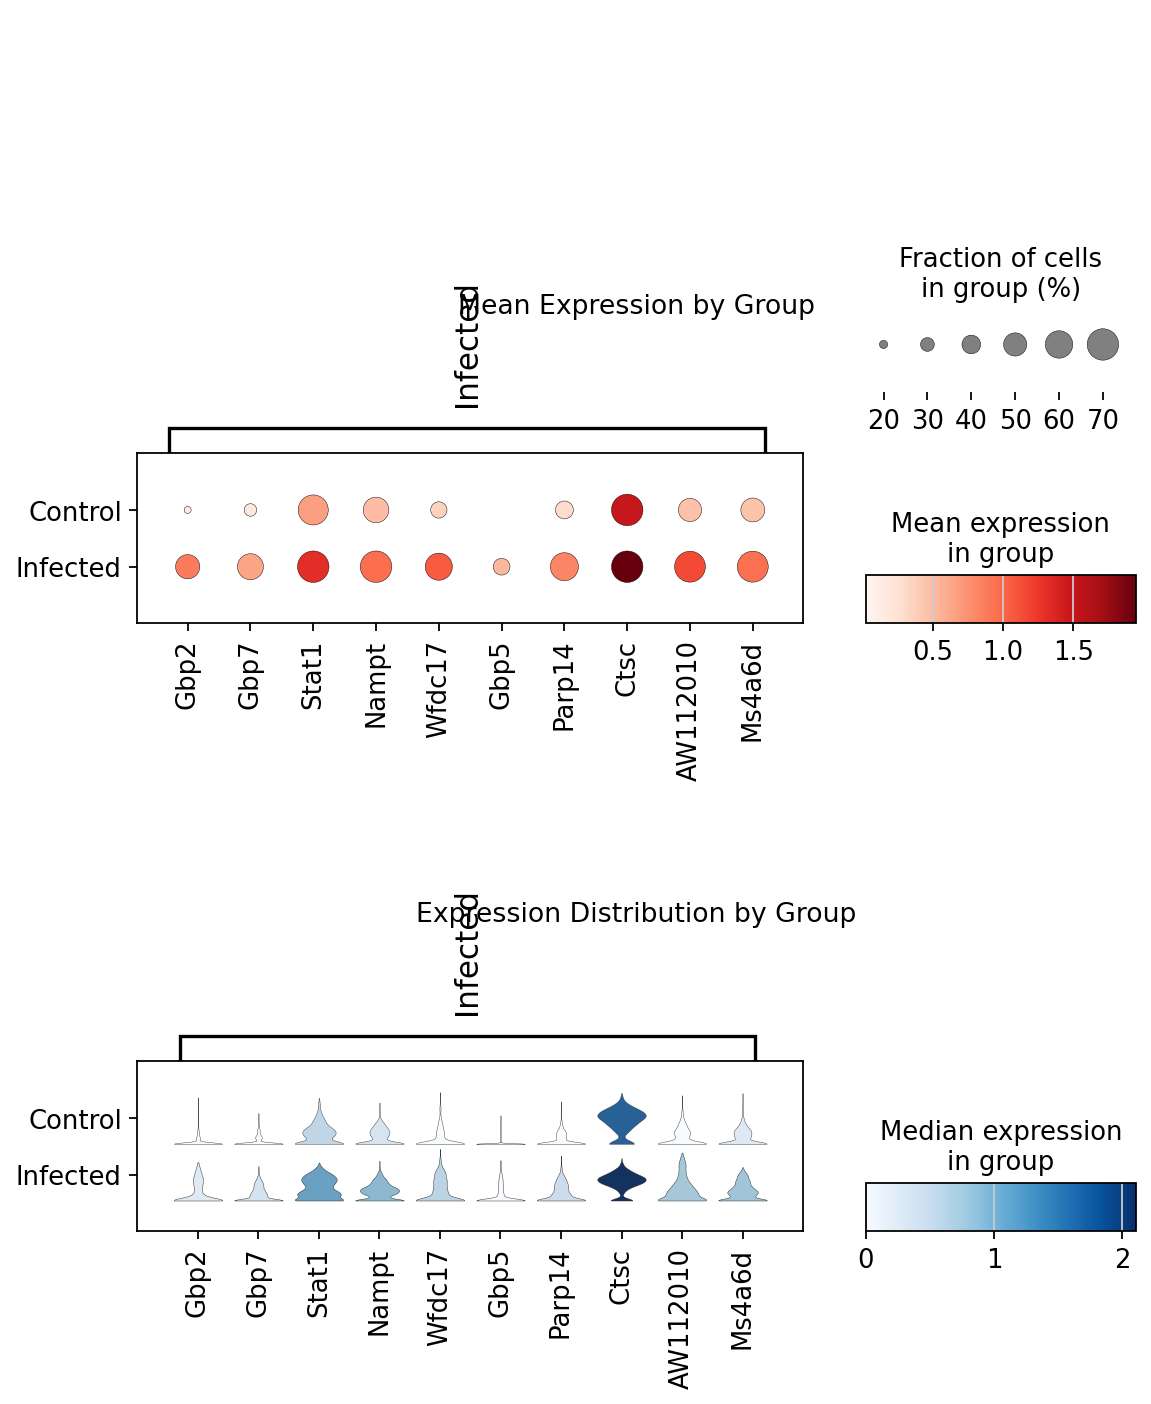

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot without showing, then remove default titles
sc.pl.rank_genes_groups_dotplot(adata, n_genes=10, key='infected_vs_control',
                               dot_max=0.7, dot_min=0.1, 
                               ax=ax1, show=False)
ax1.set_title('')  # Remove default title
ax1.text(0.5, 0.5, 'Mean Expression by Group', transform=ax1.transAxes, 
         ha='center', va='bottom', fontsize=12)

sc.pl.rank_genes_groups_stacked_violin(adata, n_genes=10, key='infected_vs_control',
                                      ax=ax2, show=False)
ax2.set_title('')  # Remove default title  
for text in ax2.texts:
    text.remove()
ax2.text(0.5, 0.5, 'Expression Distribution by Group', transform=ax2.transAxes,
         ha='center', va='bottom', fontsize=12)

plt.subplots_adjust(hspace=0)
plt.show()

### 2. Interstitial Macrophage Infection Response (IM Infected vs Control)

**Biological Question**: How do interstitial macrophages specifically respond to infection?

**Expected Findings**: Enhanced interferon/antiviral responses (Stat1, Gbp genes), tissue surveillance programs

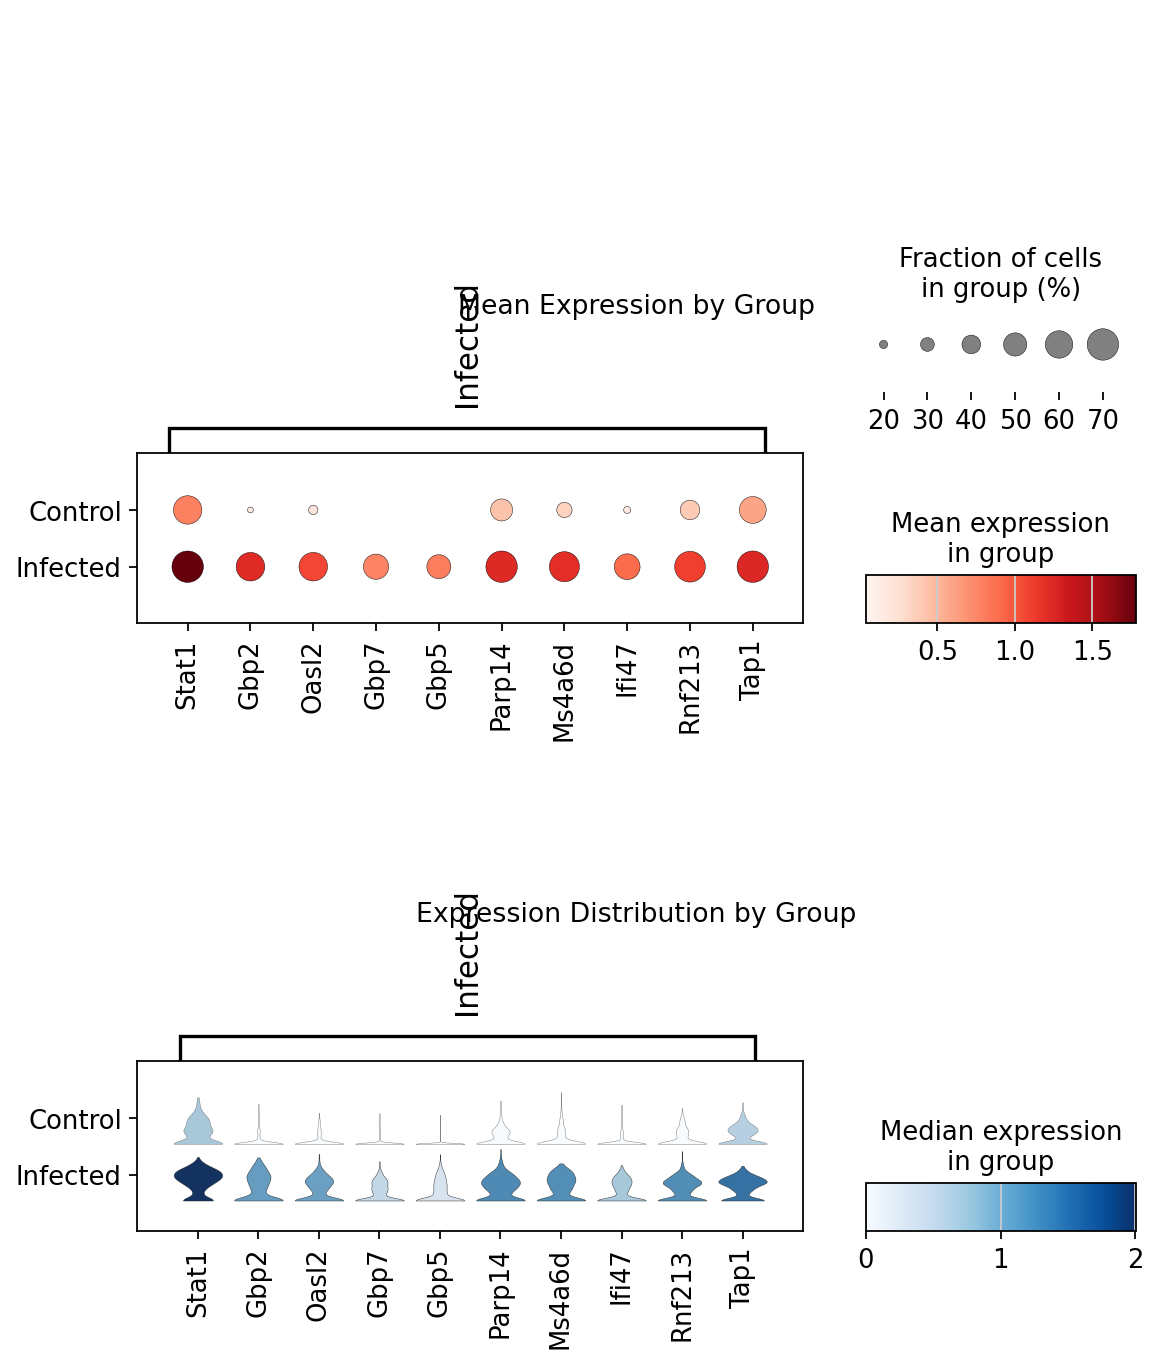

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot without showing, then remove default titles
sc.pl.rank_genes_groups_dotplot(im_cells, n_genes=10, key='im_infected_vs_control',
                               dot_max=0.7, dot_min=0.1, 
                               ax=ax1, show=False)
ax1.set_title('')  # Remove default title
ax1.text(0.5, 0.5, 'Mean Expression by Group', transform=ax1.transAxes, 
         ha='center', va='bottom', fontsize=12)

sc.pl.rank_genes_groups_stacked_violin(im_cells, n_genes=10, key='im_infected_vs_control',
                                      ax=ax2, show=False, dendrogram=False)
ax2.set_title('')  # Remove default title  
ax2.text(0.5, 0.5, 'Expression Distribution by Group', transform=ax2.transAxes,
         ha='center', va='bottom', fontsize=12)

plt.subplots_adjust(hspace=0)
plt.show()


### 3. Alveolar Macrophage Infection Response (AM Infected vs Control)

**Biological Question**: How do alveolar macrophages specifically respond to infection?

**Expected Findings**: Tissue homeostasis disruption, enhanced phagocytosis, airway-specific responses

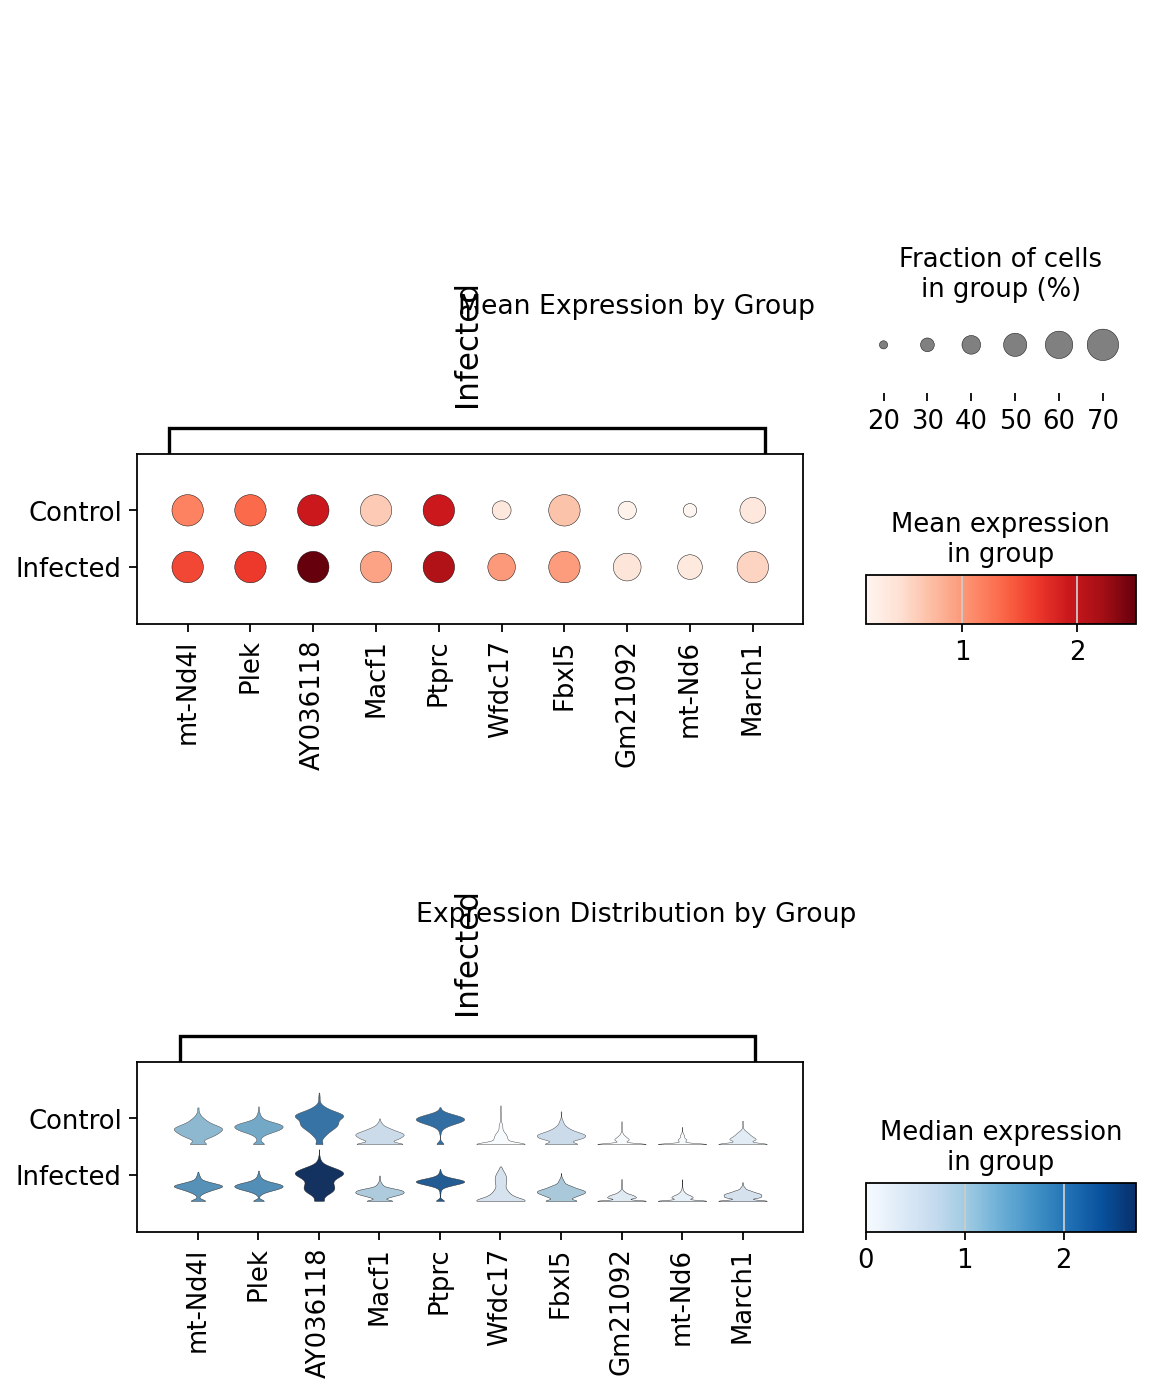

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot without showing, then remove default titles
sc.pl.rank_genes_groups_dotplot(am_cells, n_genes=10, key='am_infected_vs_control',
                               dot_max=0.7, dot_min=0.1, 
                               ax=ax1, show=False)
ax1.set_title('')  # Remove default title
ax1.text(0.5, 0.5, 'Mean Expression by Group', transform=ax1.transAxes, 
         ha='center', va='bottom', fontsize=12)

sc.pl.rank_genes_groups_stacked_violin(am_cells, n_genes=10, key='am_infected_vs_control',
                                      ax=ax2, show=False)
ax2.set_title('')  # Remove default title  
ax2.text(0.5, 0.5, 'Expression Distribution by Group', transform=ax2.transAxes,
         ha='center', va='bottom', fontsize=12)

plt.subplots_adjust(hspace=0)
plt.show()

## M(Kp) Signature Discovery

### Bacterial Contact Analysis in Infected Tissue

This section focuses on identifying the M(Kp) signature - a novel macrophage polarization state induced by direct bacterial contact.

### 4. Bacterial Contact vs Bystander Cells (Most Critical Analysis)

**Biological Question**: Within infected tissue, what distinguishes cells that directly contacted Klebsiella from bystander cells?

**Critical Importance**: This comparison identifies the M(Kp) signature - a novel macrophage state

**Expected Findings**:
- STAT6 pathway activation
- Capsule polysaccharide recognition genes  
- Novel antimicrobial programs distinct from general inflammation
- Bacterial processing and presentation genes

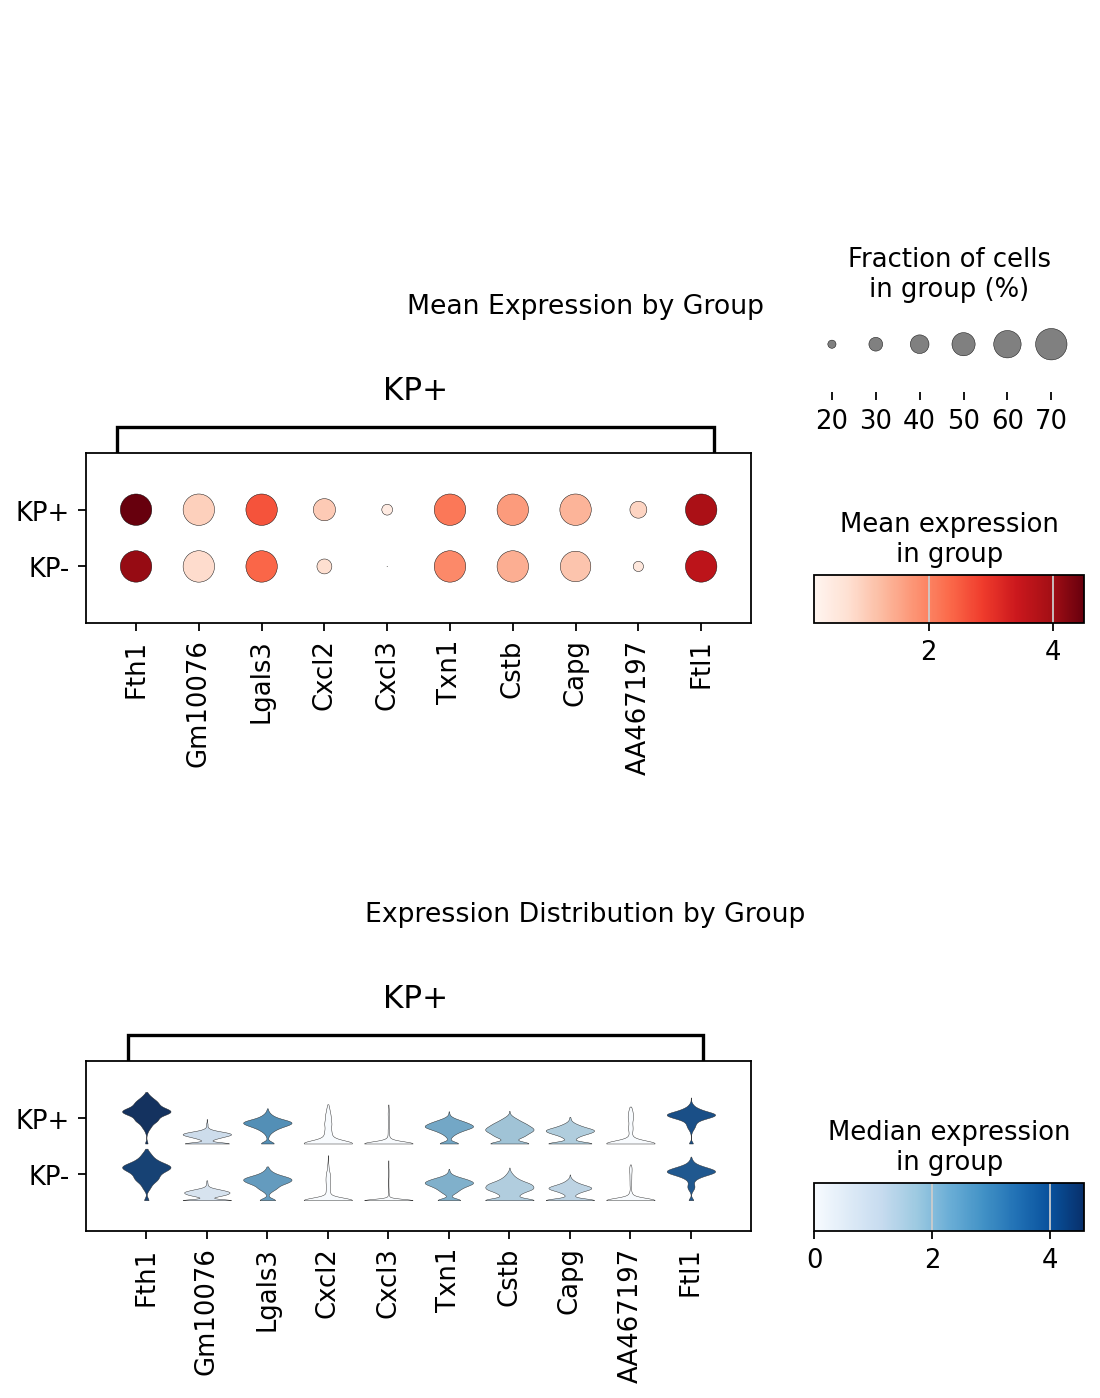

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot without showing, then remove default titles
sc.pl.rank_genes_groups_dotplot(infected_cells, n_genes=10, key='bacterial_vs_bystander',
                               dot_max=0.7, dot_min=0.1, 
                               ax=ax1, show=False)
ax1.set_title('')  # Remove default title
ax1.text(0.5, 0.5, 'Mean Expression by Group', transform=ax1.transAxes, 
         ha='center', va='bottom', fontsize=12)

sc.pl.rank_genes_groups_stacked_violin(infected_cells, n_genes=10, key='bacterial_vs_bystander',
                                      ax=ax2, show=False)
ax2.set_title('')  # Remove default title  
ax2.text(0.5, 0.5, 'Expression Distribution by Group', transform=ax2.transAxes,
         ha='center', va='bottom', fontsize=12)

plt.subplots_adjust(hspace=0)
plt.show()

### Cell Type-Specific Bacterial Contact Analysis

Examine how alveolar and interstitial macrophages respond differently to direct bacterial contact.

#### Prepare Cell Type-Specific Bacterial Contact Comparisons

In [24]:
# Create cell type-specific infected subsets for bacterial contact analysis
am_infected_cells = infected_cells[infected_cells.obs['cell_type'] == 'AM'].copy()
im_infected_cells = infected_cells[infected_cells.obs['cell_type'] == 'IM'].copy()

# Perform cell type-specific bacterial contact vs bystander analysis
sc.tl.rank_genes_groups(
    am_infected_cells,
    groupby='treatment',
    groups=['KP+'],
    reference='KP-',
    method='wilcoxon',
    key_added='am_bacterial_vs_bystander'
)

sc.tl.rank_genes_groups(
    im_infected_cells,
    groupby='treatment',
    groups=['KP+'],
    reference='KP-',
    method='wilcoxon',
    key_added='im_bacterial_vs_bystander'
)

# Transfer results back to infected_cells object for visualization
infected_cells.uns['am_bacterial_vs_bystander'] = am_infected_cells.uns['am_bacterial_vs_bystander']
infected_cells.uns['im_bacterial_vs_bystander'] = im_infected_cells.uns['im_bacterial_vs_bystander']

print("Cell type-specific bacterial contact analysis completed:")
print(f"  AM bacterial contact: {am_infected_cells.n_obs:,} cells")
print(f"  IM bacterial contact: {im_infected_cells.n_obs:,} cells")

# Show composition
print(f"\nAM infected cells composition:")
print(am_infected_cells.obs['treatment'].value_counts())
print(f"\nIM infected cells composition:")
print(im_infected_cells.obs['treatment'].value_counts())

Cell type-specific bacterial contact analysis completed:
  AM bacterial contact: 776 cells
  IM bacterial contact: 832 cells

AM infected cells composition:
treatment
KP+    395
KP-    381
Name: count, dtype: int64

IM infected cells composition:
treatment
KP-    417
KP+    415
Name: count, dtype: int64


#### 5. Alveolar Macrophage Bacterial Contact (AM KP+ vs KP-)

**Biological Question**: How do alveolar macrophages respond to direct bacterial contact?

**Focus**: AM-specific M(Kp) signature components

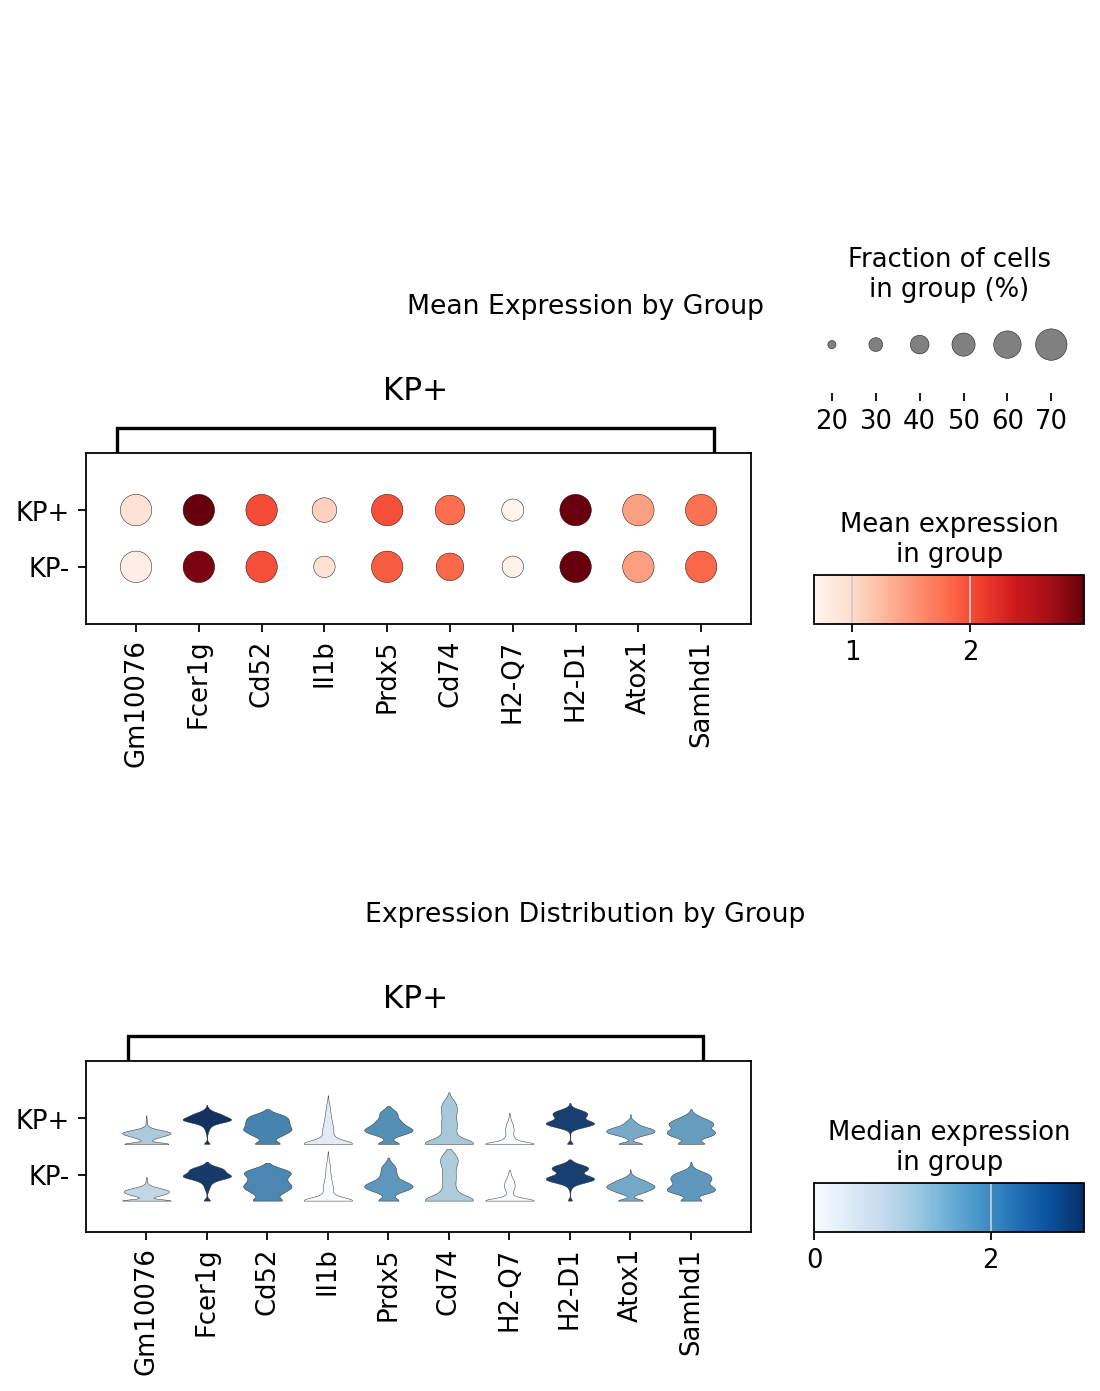

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot without showing, then remove default titles
sc.pl.rank_genes_groups_dotplot(infected_cells, n_genes=10, key='am_bacterial_vs_bystander',
                               dot_max=0.7, dot_min=0.1, 
                               ax=ax1, show=False)
ax1.set_title('')  # Remove default title
ax1.text(0.5, 0.5, 'Mean Expression by Group', transform=ax1.transAxes, 
         ha='center', va='bottom', fontsize=12)

sc.pl.rank_genes_groups_stacked_violin(infected_cells, n_genes=10, key='am_bacterial_vs_bystander',
                                      ax=ax2, show=False)
ax2.set_title('')  # Remove default title  
ax2.text(0.5, 0.5, 'Expression Distribution by Group', transform=ax2.transAxes,
         ha='center', va='bottom', fontsize=12)

plt.subplots_adjust(hspace=0)
plt.show()

#### 6. Interstitial Macrophage Bacterial Contact (IM KP+ vs KP-)

**Biological Question**: How do interstitial macrophages respond to direct bacterial contact?

**Focus**: IM-specific M(Kp) signature components and comparison with AM responses

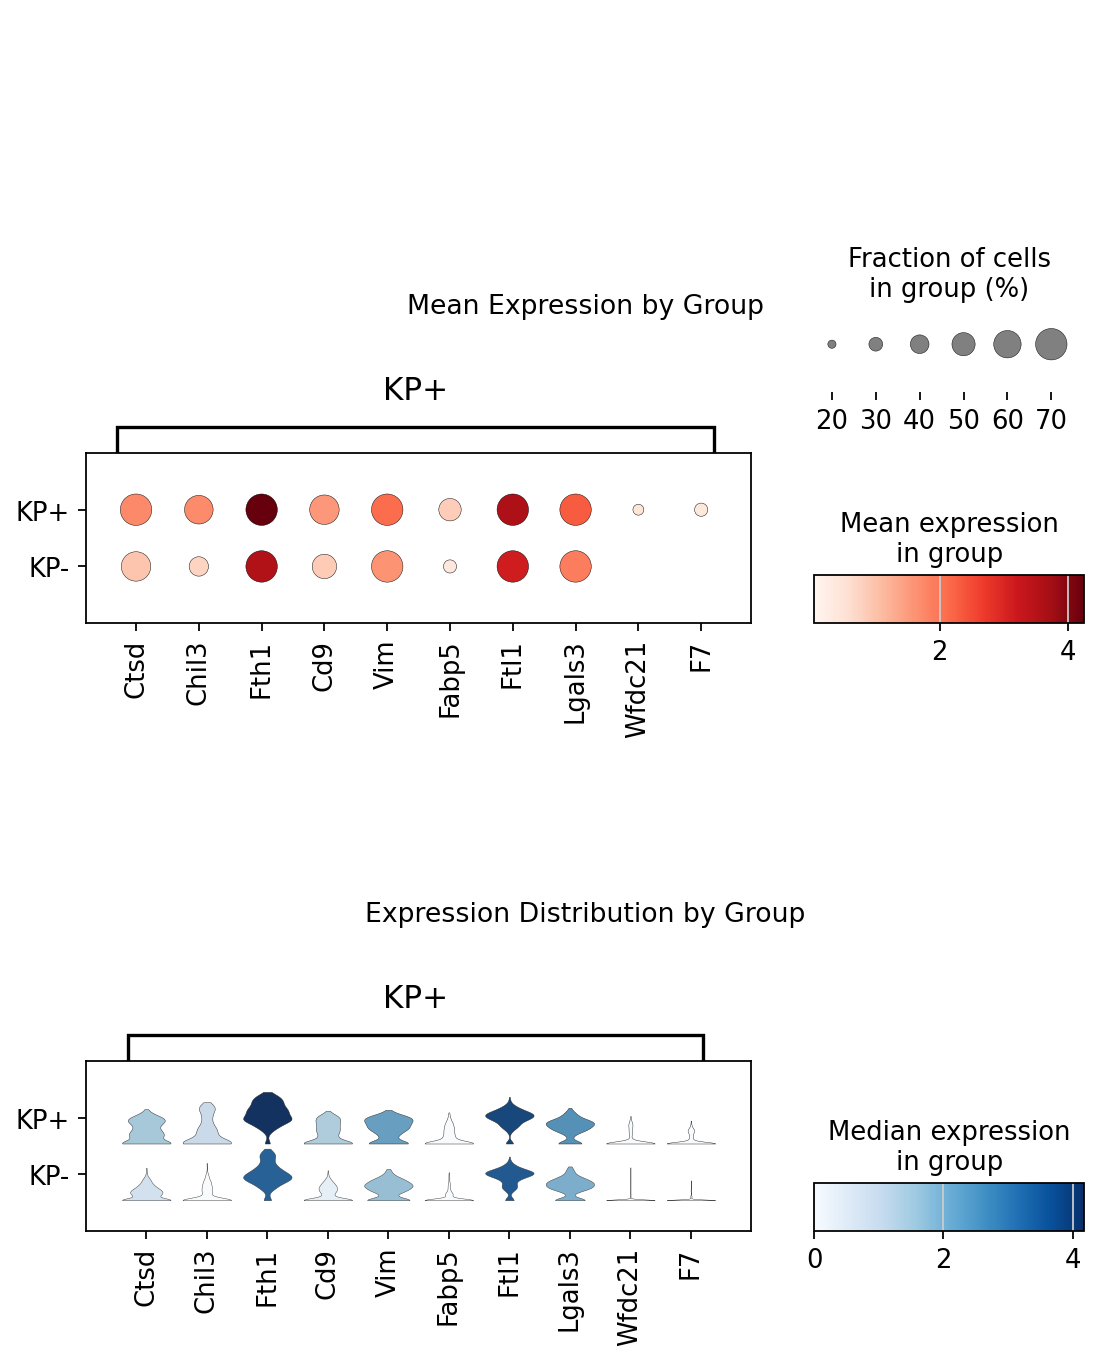

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot without showing, then remove default titles
sc.pl.rank_genes_groups_dotplot(im_infected_cells, n_genes=10, key='im_bacterial_vs_bystander',
                               dot_max=0.7, dot_min=0.1, 
                               ax=ax1, show=False)
ax1.set_title('')  # Remove default title
ax1.text(0.5, 0.5, 'Mean Expression by Group', transform=ax1.transAxes, 
         ha='center', va='bottom', fontsize=12)

sc.pl.rank_genes_groups_stacked_violin(im_infected_cells, n_genes=10, key='im_bacterial_vs_bystander',
                                      ax=ax2, show=False)
ax2.set_title('')  # Remove default title  
ax2.text(0.5, 0.5, 'Expression Distribution by Group', transform=ax2.transAxes,
         ha='center', va='bottom', fontsize=12)

plt.subplots_adjust(hspace=0)
plt.show()

In [27]:
## Data Export

### Save Analysis Results

In [28]:
# Save datasets with computed differential expression results
adata.write('condition_DE_analysis.h5ad')
infected_cells.write('infected_cells_DE.h5ad')
am_cells.write('am_cells_DE.h5ad')
im_cells.write('im_cells_DE.h5ad')

print("Differential Expression Analysis Summary:")
print(f"  Primary dataset: {adata.n_obs:,} cells with infection response analysis")
print(f"  Infected subset: {infected_cells.n_obs:,} cells with bacterial contact analysis")
print(f"  AM subset: {am_cells.n_obs:,} cells with AM-specific responses")
print(f"  IM subset: {im_cells.n_obs:,} cells with IM-specific responses")

print(f"\nCompleted Comparisons:")
print(f"  1. Overall infection response (all macrophages)")
print(f"  2. AM-specific infection response")
print(f"  3. IM-specific infection response") 
print(f"  4. Bacterial contact vs bystander (M(Kp) signature)")
print(f"  5. AM bacterial contact vs bystander")
print(f"  6. IM bacterial contact vs bystander")

print(f"\nFiles saved:")
print(f"  - condition_DE_analysis.h5ad (main dataset)")
print(f"  - infected_cells_DE.h5ad (infected tissue subset)")
print(f"  - am_cells_DE.h5ad (alveolar macrophages)")
print(f"  - im_cells_DE.h5ad (interstitial macrophages)")

# Verify saved keys
available_keys = [k for k in infected_cells.uns.keys() if 'rank' in k or 'vs' in k]
print(f"\nDifferential expression keys available: {available_keys}")

print(f"\nNext steps: Pathway enrichment analysis to validate M(Kp) signature and STAT6 activation")

Differential Expression Analysis Summary:
  Primary dataset: 2,399 cells with infection response analysis
  Infected subset: 1,608 cells with bacterial contact analysis
  AM subset: 1,151 cells with AM-specific responses
  IM subset: 1,248 cells with IM-specific responses

Completed Comparisons:
  1. Overall infection response (all macrophages)
  2. AM-specific infection response
  3. IM-specific infection response
  4. Bacterial contact vs bystander (M(Kp) signature)
  5. AM bacterial contact vs bystander
  6. IM bacterial contact vs bystander

Files saved:
  - condition_DE_analysis.h5ad (main dataset)
  - infected_cells_DE.h5ad (infected tissue subset)
  - am_cells_DE.h5ad (alveolar macrophages)
  - im_cells_DE.h5ad (interstitial macrophages)

Differential expression keys available: ['ranked_genes', 'bacterial_vs_bystander', 'am_bacterial_vs_bystander', 'im_bacterial_vs_bystander']

Next steps: Pathway enrichment analysis to validate M(Kp) signature and STAT6 activation
